In [1]:
import sys
if sys.platform == 'win32':
    sys.path.append(r"C:\Users\vl385\Documents\casadi-windows-py37-v3.5.1") 
else:
    sys.path.append(r"casadiinstalldir")
import casadi as ca

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import numpy.linalg as LA
from scipy.integrate import odeint
# from cfm import *
# import tensorflow as tf
# from tensorflow import keras
import tikzplotlib
import copy
from timeit import default_timer as timer
import sympy as sp

## Pre computation

In [19]:
p1, v1, a1 = sp.symbols('p1 v1 a1')
p2, v2 = sp.symbols('p2 v2')
w1, w2, w3, w4 = sp.symbols('w1 w2 w3 w4')
v_min, v_max = sp.symbols('v_min, v_max')
a_min, a_max = sp.symbols('a_min, a_max')
alpha, rho = sp.symbols('alpha, rho')
tau = sp.symbols('tau')

In [20]:
X = sp.Matrix([[p1],[v1]])
U = sp.Matrix([[a1]])

In [21]:
V = w2*(v1-v_max)**2 - w3*sp.log(p1**2+p2**2-2*alpha*p1*p2-rho**2) - w4*sp.log(v_max-v1) - w4*sp.log(v1)

In [154]:
V_x = sp.diff(V, X)
V_x = sp.simplify(V_x)

In [155]:
V_x

Matrix([
[       -2*w3*(alpha*p2 - p1)/(2*alpha*p1*p2 - p1**2 - p2**2 + rho**2)],
[(2*v1*w2*(v1 - v_max)**2 - v1*w4 - w4*(v1 - v_max))/(v1*(v1 - v_max))]])

In [24]:
V_xx = sp.Matrix([sp.diff(V_x[0], X).T, sp.diff(V_x[1], X).T]).T
V_xx = sp.simplify(V_xx)

In [25]:
V_xx

Matrix([
[2*w3*(2*alpha*p1*p2 - p1**2 - p2**2 + rho**2 + 2*(alpha*p2 - p1)**2)/(2*alpha*p1*p2 - p1**2 - p2**2 + rho**2)**2,                                    0],
[                                                                                                               0, 2*w2 + w4/(v1 - v_max)**2 + w4/v1**2]])

In [26]:
L_k = w1*a1**2

In [27]:
V_u = sp.diff(L_k, U)
V_u = sp.simplify(V_u)
V_u

Matrix([[2*a1*w1]])

In [28]:
V_uu = sp.Matrix([sp.diff(V_u[0], U).T]).T
V_uu = sp.simplify(V_uu)
V_uu

Matrix([[2*w1]])

# Simulation 

## Some functions

In [29]:
def in_control_zone(p, control_zone):
    if p >= control_zone[0] and p <= control_zone[1]:
        return True
    else:
        return False

def distance(p1, p2, angle):
    if p2 <= 0:
        dist = np.sqrt(p1**2 + p2**2 - 2*np.cos(angle)*p1*p2)
    elif p2 > 0:
        dist = np.abs(p1-p2)
    return dist

## Main classes


In [30]:
class HDV:
    lc = 3.0 # car length
    
    # velocity and input bounds      
    v_min = 0.0; v_max = 30.0
    u_min = -10.0; u_max = 5.0
    
    def __init__(self, x0, T = 0.1):
        self.st = x0
        self.input = 0.0
        self.T = T

        self.X_hist = np.empty([2,0], dtype=np.ndarray)
        self.U_hist = np.empty([0], dtype=float)
        self.X_hist = np.hstack([self.X_hist, x0.reshape([-1,1])])
        
    def set_cfm(self, model):
        self.model = model
        
    def update_measurement(self, st_h):
        self.p_h = st_h[0]; self.v_h = st_h[1]; self.u_h = st_h[2]
        
    def get_input(self):
        p = self.st[0]; v = self.st[1]
        delta_p = self.p_h - p - self.lc
        delta_v = self.v_h - v
        u = self.model.action(p, v, self.p_h, self.v_h, self.u_h)
            
#         u = max(self.u_min, min(self.u_max, u))
        if v + self.T*u > self.v_max:
            u = (self.v_max-v)/self.T
        elif v + self.T*u < self.v_min:
            u = (self.v_min-v)/self.T
        return u
    
    def car_model(self, z, t, u):
        p = z[0]; v = z[1]
        
        dz = np.zeros(2)
        dz[0] = v
        dz[1] = u
        return dz
        
    def run(self, u):
        tspan = np.linspace(0, self.T, 3)
        y = odeint(self.car_model, self.st, tspan, args=(u,)) 
        self.st = y[-1,] 
        self.input = u
        self.X_hist = np.hstack([self.X_hist, self.st.reshape([-1,1])])
        self.U_hist = np.hstack([self.U_hist, self.input])  
        
    def run_v(self, v):
        v = max(self.v_min, min(self.v_max, v))
        if (v - self.st[1])/self.T < self.u_min:
            v = self.st[1] + self.T*self.u_min
        elif (v - self.st[1])/self.T > self.u_max:
            v = self.st[1] + self.T*self.u_max
        y = self.st[0] + self.T*v
        self.st = np.array([y, v])
        self.X_hist = np.hstack([self.X_hist, self.st.reshape([-1,1])])
        self.U_hist = np.hstack([self.U_hist, self.input])     

In [184]:
class CAV:
    lc = 3.0 # car length
    
    # velocity and input bounds      
    v_min = 0.0; v_max = 30.0
    u_min = -10.0; u_max = 5.0
    
    def __init__(self, x0, T = 0.1):
        self.st = x0
        self.input = 0.0
        self.T = T
        self.X_hist = np.empty([2,0], dtype=np.ndarray)
        self.U_hist = np.empty([0], dtype=float)
        self.X_hist = np.hstack([self.X_hist, x0.reshape([-1,1])])
        
    def car_model(self, z, t, u):
        v = z[1]

        dz = np.zeros(2)
        dz[0] = v
        dz[1] = u
        return dz
        
    def run(self, u):
        u = max(self.u_min, min(self.u_max, u))
        v = self.st[1]
        if v + self.T*u > self.v_max:
            u = (self.v_max-v)/self.T
        elif v + self.T*u < self.v_min:
            u = (self.v_min-v)/self.T
        
        tspan = np.linspace(0, self.T, 3)
        y = odeint(self.car_model, self.st, tspan, args=(u,)) 
        self.st = y[-1,] 
        self.input = u
        self.X_hist = np.hstack([self.X_hist, self.st.reshape([-1,1])])
        self.U_hist = np.hstack([self.U_hist, self.input])        
        
    def run_v(self, v):
        v = max(self.v_min, min(self.v_max, v))
        if (v - self.st[1])/self.T < self.u_min:
            v = self.st[1] + self.T*self.u_min
        elif (v - self.st[1])/self.T > self.u_max:
            v = self.st[1] + self.T*self.u_max
        y = self.st[0] + self.T*v
        self.st = np.array([y, v])
        self.X_hist = np.hstack([self.X_hist, self.st.reshape([-1,1])])
        self.U_hist = np.hstack([self.U_hist, self.input])            

In [383]:
class CILQR:
    # velocity and input bounds      
    v_min = 0.0; v_max = 30.0
    u_min = -10.0; u_max = 5.0
    H_max = 20
    
    def __init__(self, N_HDV, H = 10, T = 0.1, gamma = 1e-4, lamda = 0.5, mu = 2.0):
        self.N = N_HDV
        self.H = H; self.T = T
        self.gamma = gamma; self.alpha = alpha; self.mu = mu
        
    def set_state(self, all_st):
        self.st = all_st[:,0]
        self.HDV_st = all_st[:,1:]
        
    def set_road_info(self, r, ang):
        self.r = r; self.alpha = np.cos(ang)
        
    def set_weight(self, W):
        self.W = W
        
    def update_HDV_set(self, N_HDV):
        self.N = N_HDV
        
    def update_horizon(self):
        H_f = int(-(self.st[0]/self.st[1])/self.T) if self.st[1] > 0 else np.inf
        self.H = max(1, min(H_f, self.H_max)) 
        
    def initialize(self):
        self.f_x = np.array([[1, self.T], [0, 1]])
        self.f_u = np.array([[self.T**2/2], [0.1]])
    
    def set_nominal(self, nom_inputs = None):
        self.nom_inputs = nom_inputs
        self.nom_states = np.zeros([2, self.H+1])
        self.nom_states[:,0] = self.st
        for k in range(self.H):
            x_k = self.nom_states[:,k]; u_k = self.nom_inputs[:,k]
            self.nom_states[:,k+1] = x_k \
                    + np.array([self.T*x_k[1]+0.5*self.T**2*u_k[0], self.T*u_k[0]])
            
    def predict_HDV(self):
        self.HDV_pred = np.zeros([self.N, 2, self.H+1])
        for i in range(self.N):
            self.HDV_pred[i,:,0] = self.HDV_st[:,i]
            for k in range(self.H):
                x_k = self.HDV_pred[i,:,k]; u_k = 0.0
                self.HDV_pred[i,:,k+1] = x_k \
                    + np.array([self.T*x_k[1]+0.5*self.T**2*u_k, self.T*u_k])
            
    def backward(self):
        X = self.nom_states[:,-1].tolist()
        for i in range(self.N):
            xhdv_k = self.HDV_pred[i,:,-1]
            X += xhdv_k.tolist()
        P1 = [self.W[1], self.W[2], self.W[3], self.alpha, self.r, self.v_max, self.v_min]
        P2 = self.W[0]
        V_k_x = self.num_V_x(X, P1); V_k_xx = self.num_V_xx(X, P1)
        
        self.q_k = np.empty(self.H, dtype=np.ndarray)
        self.Q_k = np.empty(self.H, dtype=np.ndarray)
        
        for k in range(self.H):
            X = self.nom_states[:,-2-k].tolist()
            for i in range(self.N):
                xhdv_k = self.HDV_pred[i,:,-2-k]
                X += xhdv_k.tolist()            
            
            U = self.nom_inputs[0,-1-k]

            L_k_x = self.num_V_x(X, P1); L_k_xx = self.num_V_xx(X, P1)
            L_k_u = self.num_V_u(U, P2); L_k_uu = self.num_V_uu(U, P2)
            
            P_k_x = L_k_x + np.dot(self.f_x.T, V_k_x)
            P_k_u = L_k_u + np.dot(self.f_u.T, V_k_x)
            P_k_xx = L_k_xx + LA.multi_dot([self.f_x.T, V_k_xx, self.f_x])
            P_k_uu = L_k_uu + LA.multi_dot([self.f_u.T, V_k_xx, self.f_u])
            P_k_ux = LA.multi_dot([self.f_u.T, V_k_xx, self.f_x])
            
            P_k_uu_inv = LA.inv(P_k_uu) 
            q_k = -np.dot(P_k_uu_inv, P_k_u); self.q_k[-1-k] = q_k
            Q_k = -np.dot(P_k_uu_inv, P_k_ux); self.Q_k[-1-k] = Q_k
            V_k_x = P_k_x - LA.multi_dot([P_k_u.T, P_k_uu_inv, P_k_ux]).T
            V_k_xx = P_k_xx - LA.multi_dot([P_k_ux.T, P_k_uu_inv, P_k_ux]) 
            
            
    def check_violation(self, inputs, states):
        # Check bound constraints
        violation = (np.max(inputs) > self.u_max) or (np.min(inputs) < self.u_min) \
                or (np.max(states[1,:]) > self.v_max) or (np.min(states[1,:]) < self.v_min)
                
        # Check safety constraints
        for i in range(self.N):
            dist = states[0,:]**2 + self.HDV_pred[i,0,:]**2 - 2*self.alpha*states*self.HDV_pred[i,0,:] - self.r**2
            violation = violation or np.min(dist) < 0 
            
        return violation 

    def forward(self, scale_rate = 0.5):
        nom_states = copy.deepcopy(self.nom_states)
        nom_inputs = copy.deepcopy(self.nom_inputs)
        for k in range(self.H):
            delta_x = self.nom_states[:,k] - nom_states[:,k]
            self.nom_inputs[:,k] += self.q_k[k].ravel() + np.dot(self.Q_k[k], delta_x)
            x_k = self.nom_states[:,k]; u_k = self.nom_inputs[:,k]
            self.nom_states[:,k+1] = x_k + \
                    + np.array([self.T*x_k[1]+0.5*self.T**2*u_k[0], self.T*u_k[0]])
        
        # Forward checking and apply line search 
        violated = self.check_violation(self.nom_inputs, self.nom_states)      
        while violated:   
            residual = self.nom_inputs - nom_inputs
            residual *= scale_rate
            self.nom_inputs = residual + nom_inputs
            for k in range(self.H):
                x_k = self.nom_states[:,k]; u_k = self.nom_inputs[:,k]
                self.nom_states[:,k+1] = x_k + \
                    + np.array([self.T*x_k[1]+0.5*self.T**2*u_k[0], self.T*u_k[0]])
            
            violated = self.check_violation(self.nom_inputs, self.nom_states)
            
        return LA.norm(self.nom_inputs - nom_inputs)
        
    def CILQR(self, max_iters = 100, thres = 1e-3):
        self.predict_HDV()
        for i in range(max_iters):
#             self.gamma *= self.mu
            self.backward()
            res = self.forward()
#             print(i, res)
            if res <= thres:
                break
        
    def num_V_x(self, X, P):
        p1, v1 = X[0:2] 
        w2, w3, w4, alpha, rho, v_max, v_min = P
        V = np.zeros([2,1])
        V[1,0] = 2*w2*(v1-v_max) - w3/(v1-v_max) - w3/(v1-v_min)
        for i in range(self.N):
            p2, v2 = X[2*(i+1):2*(i+2)]
            dem = (2*alpha*p1*p2-p1**2-p2**2+rho**2)
            V[0,0] += 2*w4*(-alpha*p2+p1)/dem

        return V

    def num_V_xx(self, X, P):
        p1, v1 = X[0:2] 
        w2, w3, w4, alpha, rho, v_max, v_min = P
        V = np.zeros([2,2])
        V[1,1] = 2*w2 + w3/(v1-v_max)**2 + w3/(v1-v_min)**2
        for i in range(self.N):
            p2, v2 = X[2*(i+1):2*(i+2)]
            dem = (2*alpha*p1*p2-p1**2-p2**2+rho**2)**2
            V[0,0] += 2*w4*(2*alpha*p1*p2-p1**2-p2**2+rho**2+2*(alpha*p2-p1)**2)/dem
        return V

    def num_V_u(self, U, P):
        a1 = U
        w1 = P
        V = np.zeros([1,1])
        V[0,0] = 2*w1*a1 
        return V

    def num_V_uu(self, U, P):
        a1 = U
        w1 = P
        V = np.zeros([1,1])
        V[0,0] = 2*w1
        return V


## Main program

In [410]:
np.random.seed(28)
T = 0.1; H = 20
HDV_ego = [False, False]
control_zone = np.array([-120, 0])

cars = []
cars.append(CAV(np.array([-150.0, 25.0])))
cars.append(HDV(np.array([-140.0, 25.0])))
cars.append(HDV(np.array([-160.0, 25.0])))
n_cars = len(cars)
N_HDV = n_cars - 1

control = CILQR(N_HDV, H, T)  
W = np.array([1.,3.,1e2, 1e3])
control.set_weight(W)
r = 20; ang = np.pi/6; v_ref = 25
control.set_road_info(r, ang)
control.initialize()
all_st = np.array([cars[i].st for i in range(N_HDV+1)]).T
control.set_state(all_st)
control.set_nominal(nom_inputs = np.zeros([1, H]))

start = timer()
control.CILQR()
end = timer()
# print((end-start)*1e3)
# control.set_nominal(control.nom_inputs)

L = 200 # number of simulation steps

In [411]:
enter_t = 0; exit_t = L
for t in range(L):
    print("Time step %s" %t)
    
    # Check in control zone or not
    in_CZ = [in_control_zone(car.st[0], control_zone) for car in cars] 
    if in_CZ[0]:  # CAV is in control zone
        if enter_t == 0: enter_t = t
        # Collect states of all vehicles in control zone
        control.update_HDV_set(sum(in_CZ)-1)
        all_st = np.array([cars[i].st for i in [i for i, x in enumerate(in_CZ) if x]]).T
        control.set_state(all_st)
        
        start = timer()
        control.CILQR()
        end = timer()
        print((end-start)*1e3)
        cars[0].run(control.nom_inputs[0,0])
        control.set_nominal(nom_inputs = np.zeros([1, H]))

    else:
        cars[0].run_v(v_ref)        
        
    
    for i in range(N_HDV):
        if in_CZ[i+1]:
            if HDV_ego[i]:
                cars[i+1].run(min(cars[i+1].u_max, (cars[i+1].v_max-cars[i+1].st[1])/T))   
            else:
                cars[i+1].run(max(cars[i+1].u_min, (cars[i+1].v_min-cars[i+1].st[1])/T))   
        else:
            cars[i+1].run_v(v_ref)        

    if not in_CZ[0]:
        if exit_t == L and enter_t != 0: exit_t = t+1
    


Time step 0
Time step 1
Time step 2
Time step 3
Time step 4
Time step 5
Time step 6
Time step 7
Time step 8
Time step 9
Time step 10
Time step 11
Time step 12
11.819800000012037
Time step 13
9.345676999146235
Time step 14
10.114509999766597
Time step 15
11.80817400017986
Time step 16
11.898466998900403
Time step 17
11.978901999100344
Time step 18
12.991060000786092
Time step 19
24.599828000646085
Time step 20
18.013303000770975
Time step 21
41.2468260001333
Time step 22
31.343468001068686
Time step 23
41.37468899898522
Time step 24
25.948197000616346
Time step 25
45.425506999890786
Time step 26
33.468052999523934
Time step 27
19.837197000015294
Time step 28
13.372635999985505
Time step 29
11.753574999602279
Time step 30
14.032930999746895
Time step 31
18.09916499951214
Time step 32
15.558095999949728
Time step 33
12.84867399954237
Time step 34
12.820149000617675
Time step 35
12.775941000654711
Time step 36
12.557300000480609
Time step 37
12.546865000331309
Time step 38
12.3761939994437

In [412]:
L = cars[0].X_hist[0,:].shape[0]
X_hist = np.zeros((n_cars,3,L))

for i in range(n_cars):
    X_hist[i,0,:] = cars[i].X_hist[0,:]
    X_hist[i,1,:] = cars[i].X_hist[1,:]
    X_hist[i,2,:-1] = cars[i].U_hist


Text(0, 0.5, 'Position (m)')

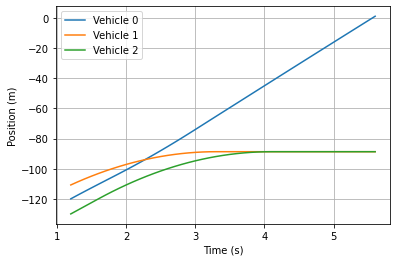

In [413]:
t_series = T*np.linspace(0,L-1,num=L)

for i in range(n_cars):
    plt.plot(t_series[enter_t:exit_t], X_hist[i,0,:][enter_t:exit_t], label = "Vehicle " + str(i))
plt.grid()
plt.legend(loc="upper left")
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
# filename = 'plots/postion.png'
# plt.savefig(filename)
# filename = 'plots/position' +'.tex'
# tikzplotlib.save(filename)

Text(0, 0.5, 'Velocity (m)')

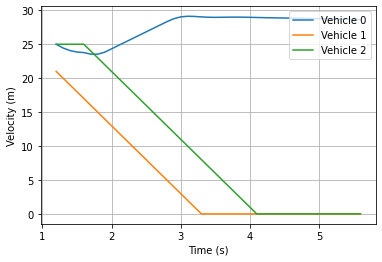

In [414]:
for i in range(n_cars):
    plt.plot(t_series[enter_t:exit_t], X_hist[i,1,:][enter_t:exit_t], label = "Vehicle " + str(i))
plt.grid()
plt.legend(loc="upper right")
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m)')
# filename = 'plots/velocity.png'
# plt.savefig(filename)
# filename = 'plots/velocity' +'.tex'
# tikzplotlib.save(filename)

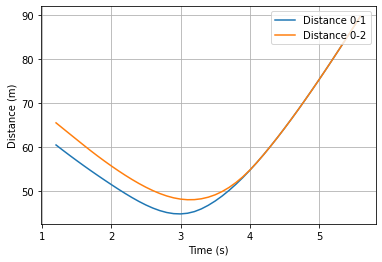

In [415]:
d = np.zeros([N_HDV,L])
for i in range(N_HDV):
    for k in range(L):
        p1 = X_hist[0,0,k]; p2 = X_hist[i+1,0,k]
        d[i,k] = distance(p1, p2, ang)
    
for i in range(N_HDV):
    plt.plot(t_series[enter_t:exit_t], d[i, enter_t:exit_t], label = "Distance " + str(0) + "-" + str(i+1))
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Distance (m)')
plt.legend(loc="upper right")
# filename = 'plots/distance.png'
# plt.savefig(filename)
# filename = 'plots/distance' +'.tex'
# tikzplotlib.save(filename)